# Banks Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

random_state = np.random.seed(12)
pd.set_option('display.max_columns', None)

## 1 - Obtaining the Initial Dataset

In [2]:
bank_marketing = fetch_ucirepo(id=222) 

In [3]:
initial_features = bank_marketing.data.features
initial_targets = bank_marketing.data.targets

processed_features = initial_features.copy()
processed_targets = initial_targets.copy()

In [4]:
initial_features

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [5]:
initial_targets

,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


## 2 - Processing the Dataset

### 2.1 - Processing Ordinal Categorical Feature Values

In [6]:
def ordinal(initial, key, values, is_object=False, default=0):
    data = initial.copy()
    data[key] = initial[key].apply(lambda value: values.index(value) if not is_object else values.get(value) if values.get(value) != None else default)
    return data

#### 2.1.1 - Education

In [7]:
print(f"Initial Value Counts\n{processed_features['education'].value_counts()}\n")
processed_features = ordinal(processed_features, 'education', {"primary": 1, "secondary": 2, "tertiary": 3}, is_object=True)
print(f"Final Value Counts\n{processed_features['education'].value_counts()}")

Initial Value Counts
education
secondary    23202
tertiary     13301
primary       6851
Name: count, dtype: int64

Final Value Counts
education
2    23202
3    13301
1     6851
0     1857
Name: count, dtype: int64


#### 2.1.2 - Default

In [8]:
print(f"Initial Value Counts\n{processed_features['default'].value_counts()}\n")
processed_features = ordinal(processed_features, 'default', ['no', 'yes'])
print(f"Final Value Counts\n{processed_features['default'].value_counts()}")

Initial Value Counts
default
no     44396
yes      815
Name: count, dtype: int64

Final Value Counts
default
0    44396
1      815
Name: count, dtype: int64


#### 2.1.3 - Housing

In [9]:
print(f"Initial Value Counts\n{processed_features['housing'].value_counts()}\n")
processed_features = ordinal(processed_features, 'housing', ['no', 'yes'])
print(f"Final Value Counts\n{processed_features['housing'].value_counts()}")

Initial Value Counts
housing
yes    25130
no     20081
Name: count, dtype: int64

Final Value Counts
housing
1    25130
0    20081
Name: count, dtype: int64


#### 2.1.4 - Loan

In [10]:
print(f"Initial Value Counts\n{processed_features['loan'].value_counts()}\n")
processed_features = ordinal(processed_features, 'loan', ['no', 'yes'])
print(f"Final Value Counts\n{processed_features['loan'].value_counts()}")

Initial Value Counts
loan
no     37967
yes     7244
Name: count, dtype: int64

Final Value Counts
loan
0    37967
1     7244
Name: count, dtype: int64


#### 2.1.5 - Month

In [11]:
print(f"Initial Value Counts\n{processed_features['month'].value_counts()}\n")
processed_features = ordinal(processed_features, 'month', ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
print(f"Final Value Counts\n{processed_features['month'].value_counts()}")

Initial Value Counts
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64

Final Value Counts
month
4     13766
6      6895
7      6247
5      5341
10     3970
3      2932
1      2649
0      1403
9       738
8       579
2       477
11      214
Name: count, dtype: int64


#### 2.1.6 - POutcome

In [12]:
print(f"Initial Value Counts\n{processed_features['poutcome'].value_counts()}\n")
processed_features = ordinal(processed_features, 'poutcome', {"other": -1, "failure": 0, "success": 1}, is_object=True, default=-2)
print(f"Final Value Counts\n{processed_features['poutcome'].value_counts()}")

Initial Value Counts
poutcome
failure    4901
other      1840
success    1511
Name: count, dtype: int64

Final Value Counts
poutcome
-2    36959
 0     4901
-1     1840
 1     1511
Name: count, dtype: int64


### 2.2 - Processing Non-Ordinal Categorical Feature Values

In [13]:
def non_ordinal(initial, key, values):
    data = initial.copy()
    for value in values:
        data[f"{value}-{key}"] = (initial[key] == value).astype(int)
    data.drop([key], axis=1, inplace=True)
    return data

#### 2.2.1 - Job

In [14]:
processed_features = non_ordinal(processed_features, 'job', ["admin.", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services"])

#### 2.2.2 - Marital

In [15]:
processed_features = non_ordinal(processed_features, 'marital', ["married", "divorced", "single"])

#### 2.2.3 - Contact

In [16]:
processed_features = non_ordinal(processed_features, 'contact', ["telephone", "cellular"])

### 2.3 - Validating the Processed Feature Values

In [17]:
print("Shape =", initial_features.shape)
initial_features

Shape = (45211, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [18]:
print("Shape =", processed_features.shape)
processed_features

Shape = (45211, 29)


,age,education,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,previous,poutcome,admin.-job,unemployed-job,management-job,housemaid-job,entrepreneur-job,student-job,blue-collar-job,self-employed-job,retired-job,technician-job,services-job,married-marital,divorced-marital,single-marital,telephone-contact,cellular-contact
0,58,3,0,2143,1,0,5,4,261,1,-1,0,-2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,44,2,0,29,1,0,5,4,151,1,-1,0,-2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,33,2,0,2,1,1,5,4,76,1,-1,0,-2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,47,0,0,1506,1,0,5,4,92,1,-1,0,-2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,33,0,0,1,0,0,5,4,198,1,-1,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,3,0,825,0,0,17,10,977,3,-1,0,-2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
45207,71,1,0,1729,0,0,17,10,456,2,-1,0,-2,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
45208,72,2,0,5715,0,0,17,10,1127,5,184,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
45209,57,2,0,668,0,0,17,10,508,4,-1,0,-2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


### 2.4 - Processing Binary Target Values

In [19]:
print(f"Initial Value Counts\n{processed_targets['y'].value_counts()}\n")
processed_targets = ordinal(processed_targets, 'y', ['no', 'yes'])
print(f"Final Value Counts\n{processed_targets['y'].value_counts()}")

Initial Value Counts
y
no     39922
yes     5289
Name: count, dtype: int64

Final Value Counts
y
0    39922
1     5289
Name: count, dtype: int64


### 2.5 - Validating the Processed Target Values

In [20]:
print("Shape =", initial_targets.shape)
initial_targets

Shape = (45211, 1)


,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


In [21]:
print("Shape =", processed_targets.shape)
processed_targets

Shape = (45211, 1)


,y
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


## 3 - Splitting the Dataset

In [22]:
split_proportion = 0.7
dataset_size = processed_features.shape[0]
train_size = int(dataset_size * split_proportion)
test_size = dataset_size - train_size

In [23]:
x_train, y_train = processed_features.iloc[train_size:], processed_targets.iloc[train_size:]['y']
x_test, y_test = processed_features.iloc[:train_size], processed_targets.iloc[:train_size]['y']

print(f"Shape of x_train = {x_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of x_test = {x_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of x_train = (13564, 29)
Shape of y_train = (13564,)
Shape of x_test = (31647, 29)
Shape of y_test = (31647,)


## 4 - Supervised Model

In [24]:
def display_results(accuracy, confusion_matrix, classification_report, predictions):
    print(f"Accuracy = {accuracy:.5f}\n")
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=np.unique(predictions))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    print(classification_report)

In [25]:
def train_test_eval(model, x_train_set, y_train_set, x_test_set, y_test_set):
    model.fit(x_train_set, y_train_set)
    y_pred_set = model.predict(x_test_set).astype(int)
    results = (y_pred_set == y_test_set).value_counts()
    accuracy = float(results[True] / y_test_set.shape[0])
    return {
        "predictions": y_pred_set,
        "accuracy": accuracy,
        "confusion_matrix": confusion_matrix(y_test_set, y_pred_set),
        "classification_report": classification_report(y_test_set, y_pred_set)
    }

Accuracy = 0.92925



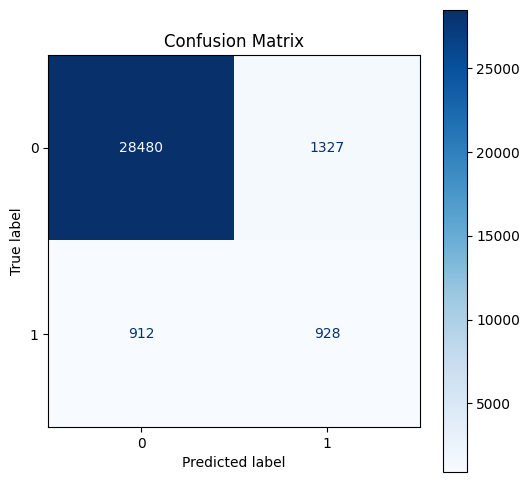

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     29807
           1       0.41      0.50      0.45      1840

    accuracy                           0.93     31647
   macro avg       0.69      0.73      0.71     31647
weighted avg       0.94      0.93      0.93     31647



In [26]:
logistic_regression_model = LogisticRegression(n_jobs=-1)
logistic_regression_results = train_test_eval(logistic_regression_model, x_train, y_train, x_test, y_test)
display_results(**logistic_regression_results)

## 5 - Unsupervised Model

Accuracy = 0.65371



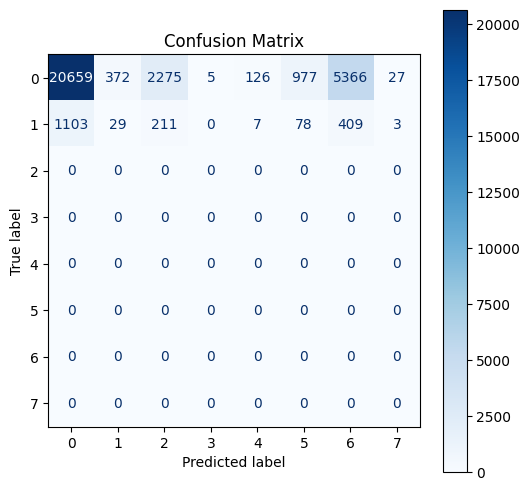

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     29807
           1       0.07      0.02      0.03      1840
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.65     31647
   macro avg       0.13      0.09      0.10     31647
weighted avg       0.90      0.65      0.76     31647



In [27]:
k_means_model = KMeans()
k_means_results = train_test_eval(k_means_model, x_train, y_train, x_test, y_test)
display_results(**k_means_results)